In [1]:
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/74/ee/d872c12ea508f9cca4cf0d7b91fc5a5e476cec77628a66795ec5a585a67f/torchvision-0.4.2-cp37-cp37m-manylinux1_x86_64.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/m/home/home7/70/viitala1/unix/miniconda3/lib/python3.7/site-packages/torch-1.3.1.dist-info/METADATA'



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import time
from random import sample

from IPython.display import clear_output
import cv2
import random

In [15]:
from donkeycar.gym import remote_controller

using donkey v3.1.1 ...


In [5]:
control = remote_controller.DonkeyRemoteContoller("kari_main", "mqtt.eclipse.org")

(clean_session) connecting to broker mqtt.eclipse.org
connected.
connecting to broker mqtt.eclipse.org
connected.


In [10]:
control.take_action([1, 0])

In [133]:
control.take_action((0,0))

In [134]:
ims = []
random_episodes = 10


for i in range(random_episodes):
    print(i)
    control.take_action([0, 0])
    time.sleep(2)
    im = control.observe()
    darkness = len(im[(im > 120) * (im < 130)])

    while darkness > 2500:
        
        im = np.dot(im[...,:3], [0.299, 0.587, 0.114])
        im = cv2.resize(im, (40, 40))
        
        ims.append(im)
        
        steering = (np.random.rand() - 0.5) * 2
        throttle = np.random.rand() / 2
        control.take_action((steering, throttle))
        im = control.observe()
        darkness = len(im[(im > 120) * (im < 130)])
        time.sleep(0.1)
    

0
1
2
3
4
5
6
7
8
9


In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
ims = []
files = ["./models/" + x for x in os.listdir("./models") if "cam" in x]

for i, file in enumerate(files):
    clear_output(wait=True)
    print(i)
    with open(file, "rb") as f:
        ims.append(plt.imread(f, format="jpeg"))



23123


NameError: name 'im' is not defined

In [4]:
len(ims)

23124

In [5]:
def gs(im):
     return np.dot(im[40:, :, :3], [0.299, 0.587, 0.114])

In [6]:
im_tensors = [torch.FloatTensor(gs(x)[np.newaxis]) for x in ims]

In [111]:
stacked_ims = []

In [108]:
gs_ims = [gs(x) for x in ims]

In [112]:
for i in range(3, len(ims)):
    stacked_ims.append(np.stack((gs_ims[i], gs_ims[i - 1], gs_ims[i - 2], gs_ims[i - 3])))

In [7]:
random.shuffle(im_tensors)

In [9]:
train = im_tensors[:19000]
test = im_tensors[19000:]

In [102]:
trainloader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size = 64, shuffle=True)

In [11]:
class EncoderDeepConv(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeepConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(10*20*16, 250)
        self.fc2 = nn.Linear(250, n_components)

    def forward(self, x, verbose=False):
        if verbose: print('Encoder')
        if verbose: print(x.shape)
        x = F.relu(self.conv1(x))
        if verbose: print(x.shape)
        x = F.relu(self.conv2(x))
        if verbose: print(x.shape)
        x = x.view(-1, self.fc1.in_features)
        if verbose: print(x.shape)
        x = F.relu(self.fc1(x))
        if verbose: print(x.shape)
        x = self.fc2(x)
        if verbose: print(x.shape)
        return x

In [12]:
class DecoderDeepConv(nn.Module):
    def __init__(self, n_components):
        super(DecoderDeepConv, self).__init__()        
        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, 10*20*16)
        self.conv1 = nn.ConvTranspose2d(in_channels = 16, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.ConvTranspose2d(in_channels = 6, out_channels = 1, kernel_size=5, padding=2, stride = 2, output_padding = 1)
    

    def forward(self, x, verbose=False):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 16, 10, 20)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        
        return x

In [13]:
class EncoderDeepConv(nn.Module):
    def __init__(self, im_cols, im_rows, n_components):
        super(EncoderDeepConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(im_rows // 8 *im_cols // 8 * 64, 250)
        self.fc2 = nn.Linear(250, n_components)

    def forward(self, x, verbose=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        #print(x.shape)
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    
class DecoderDeepConv(nn.Module):
    def __init__(self, im_cols, im_rows, n_components):
        super(DecoderDeepConv, self).__init__()        
        
        self.im_rows = im_rows
        self.im_cols = im_cols

        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, im_cols // 8 * im_rows // 8 * 64)
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, padding=2, stride=1)#, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, padding=2, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, padding=2, stride=2, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, padding=2, stride=2, output_padding=1)


    def forward(self, x, verbose=False):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, self.im_rows // 8, self.im_cols // 8)
        #print(x.shape)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)

        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_components = 10

encoder = EncoderDeepConv(160, 80, n_components)
encoder.to(device)

decoder = DecoderDeepConv(160, 80, n_components)
decoder.to(device)

criterion = nn.MSELoss()
parameters = (list(encoder.parameters())) + list(decoder.parameters())

optimizer = torch.optim.Adam(parameters, lr=0.001)

In [103]:
best_loss = 10000000000
    
for epoch in range(10):
    running_loss = 0.0
    
    for i, inputs in enumerate(trainloader):
        inputs = inputs.to(device)
            
        optimizer.zero_grad()
        
        encoder_outputs = encoder(inputs)
        decoder_outputs = decoder(encoder_outputs)
        
        #print(encoder_outputs.shape)
        #print(decoder_outputs.shape)
        
        loss = criterion(decoder_outputs, inputs)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:    # print every 200 mini-batches
            
            for test_inputs in testloader:
                with torch.no_grad():
                    encoder_outputs = encoder(inputs)
                    decoder_outputs = decoder(encoder_outputs)
                    
                    loss += criterion(decoder_outputs, inputs)
                    
            if loss < best_loss:
                print("Saving model")
                save()
                best_loss = loss
                        
                    
            print('[%d, %5d] loss: %.5f test: %.5f' %
                  (epoch+1, i+1, running_loss, loss.item()))
            running_loss = 0.0
            loss = 0.0
            

Saving model
[1,   100] loss: 11998.03433 test: 7953.95654
[1,   200] loss: 12085.63633 test: 8032.04297
Saving model
[2,   100] loss: 11968.93044 test: 7704.51416
[2,   200] loss: 11996.55576 test: 7785.28760
Saving model
[3,   100] loss: 12015.85772 test: 7589.40820
[3,   200] loss: 11863.10867 test: 7980.75635
[4,   100] loss: 11938.52169 test: 7734.91016
Saving model
[4,   200] loss: 11792.62067 test: 7493.44873
[5,   100] loss: 11820.99297 test: 7540.93115
[5,   200] loss: 11838.66830 test: 8380.76367
[6,   100] loss: 11833.00224 test: 8472.82812
Saving model
[6,   200] loss: 11777.30035 test: 7109.33838
[7,   100] loss: 11748.78149 test: 7432.36328
[7,   200] loss: 11639.95961 test: 7371.52295
[8,   100] loss: 11557.19673 test: 7617.34570
[8,   200] loss: 11760.78810 test: 8076.66699
[9,   100] loss: 11602.70102 test: 7698.53809
[9,   200] loss: 11573.37489 test: 7990.81738
[10,   100] loss: 11490.19398 test: 7164.09180
[10,   200] loss: 11572.69637 test: 7416.84375


In [97]:
for p in optimizer.param_groups:
    p["lr"] = 0.0001

In [106]:
def save():
    torch.save(decoder.state_dict(), "./decoder.pth")
    torch.save(encoder.state_dict(), "./encoder.pth")

In [107]:
save()

In [17]:
import matplotlib.pyplot as plt

In [205]:
def explore(index, value, im):
    embedding = encoder(im[np.newaxis, :].to(device))
    embedding[0][index] *= value
    embedding = embedding.to(device)
    reconstruction = decoder(embedding).detach().cpu()
    
    plt.figure(1, (10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction.squeeze())
    plt.show()

0


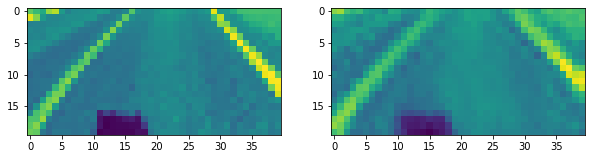

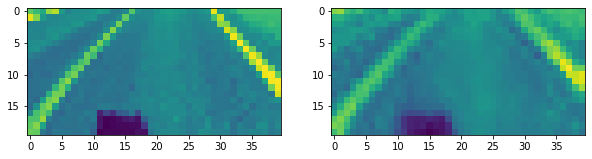

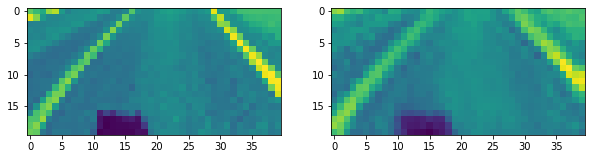

1


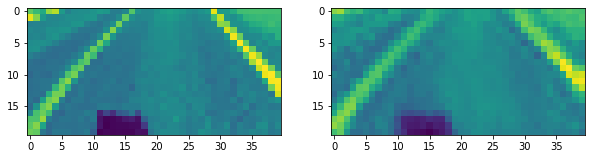

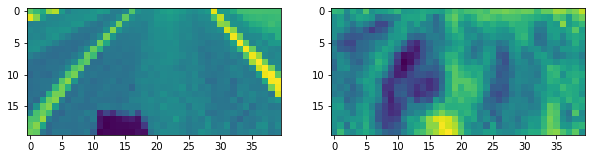

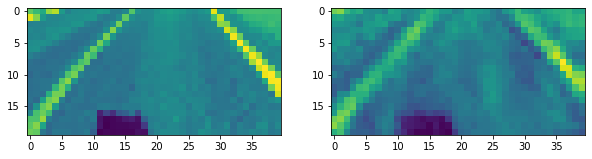

2


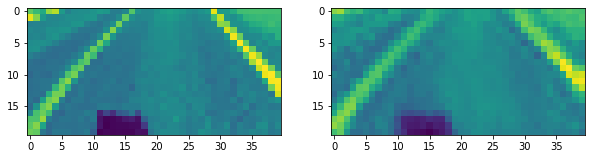

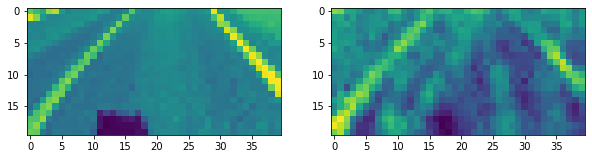

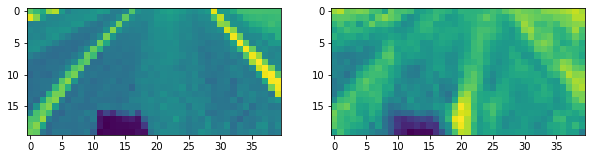

3


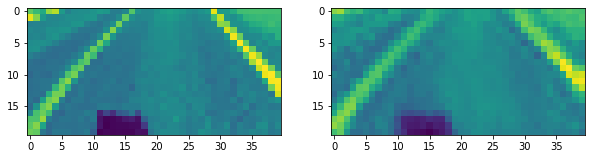

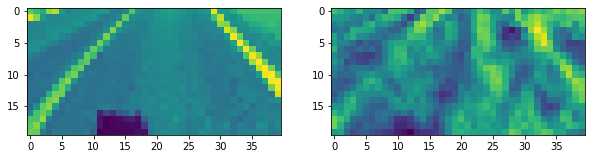

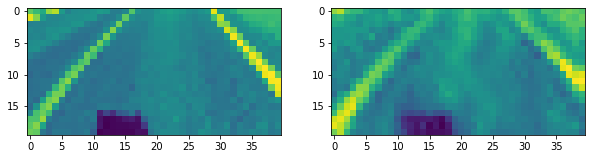

4


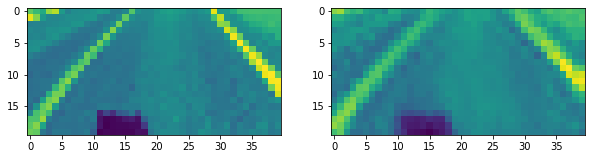

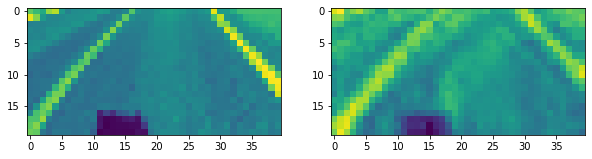

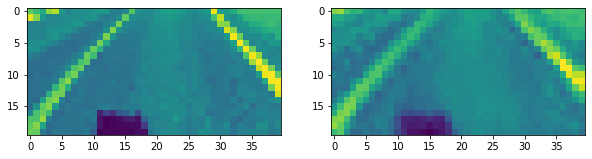

5


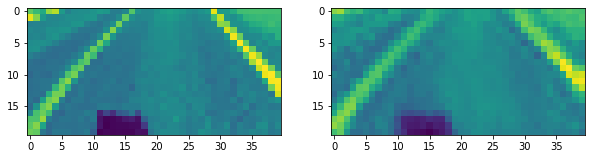

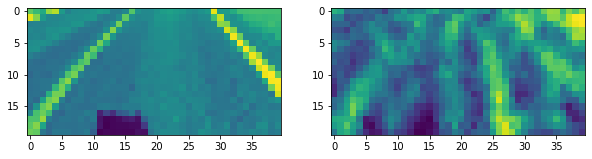

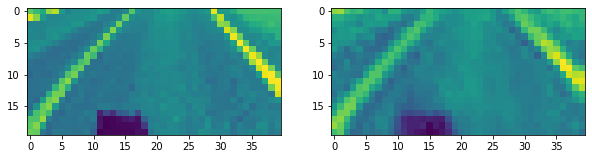

6


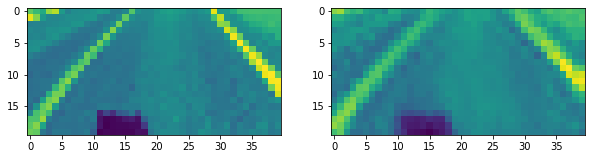

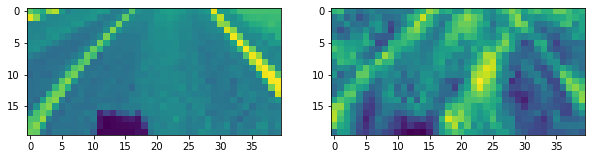

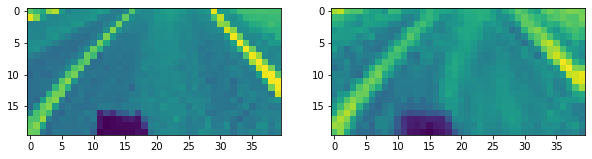

7


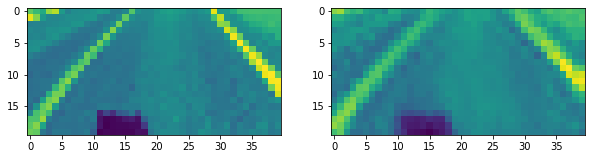

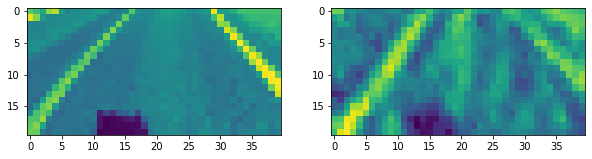

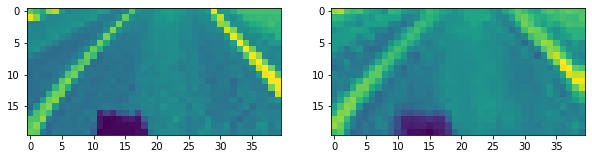

8


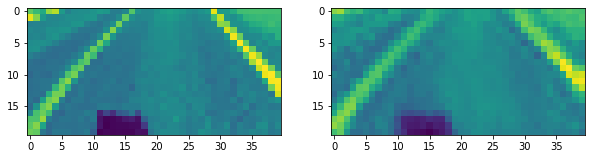

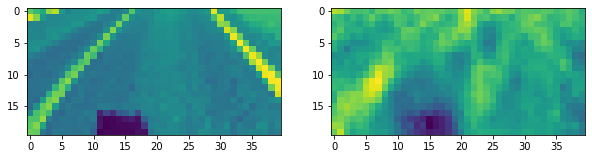

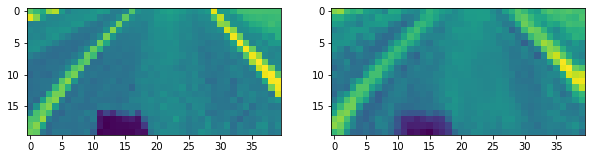

9


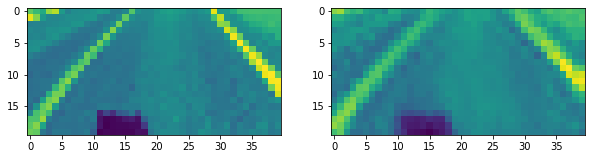

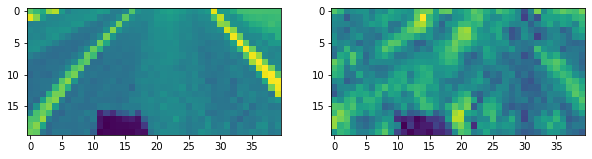

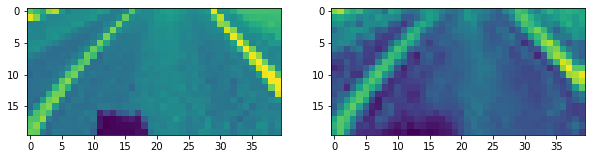

In [193]:
for i in range(10):
    print(i)
    explore(i, 1, test[10])
    explore(i, 10, test[10])
    explore(i, 0.1, test[10])

tensor([-0.0485, -1.2128,  2.2249, -1.1450, -0.2074,  0.5233, -0.6730,  0.3442,
        -0.3826, -1.0429], device='cuda:0', grad_fn=<SelectBackward>)


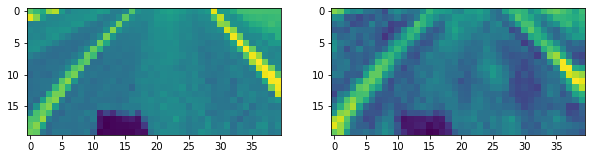

In [184]:
explore(0, 1, test[10])
explore(0, 100, test[10])
explore(0, 0.1, test[10])

tensor([-0.0485, -1.2128,  2.2249, -1.1450, -0.2074,  0.5233, -0.6730,  0.3442,
        -0.3826, -1.0429], device='cuda:0', grad_fn=<SelectBackward>)


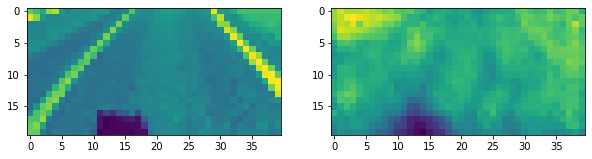

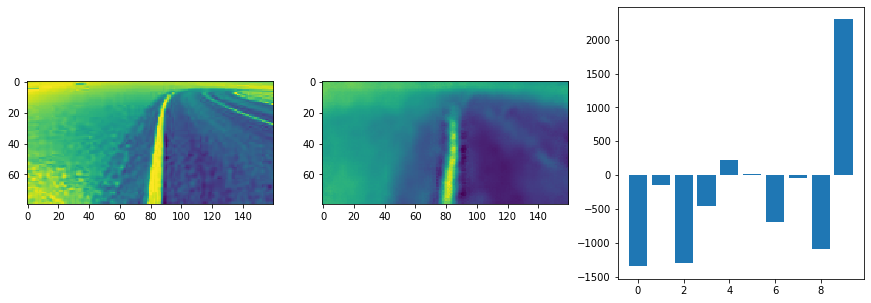

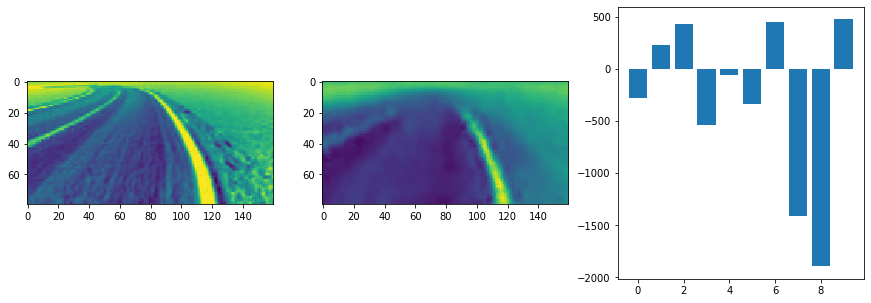

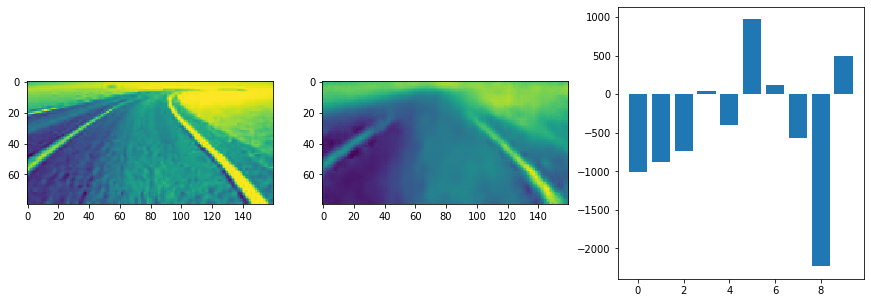

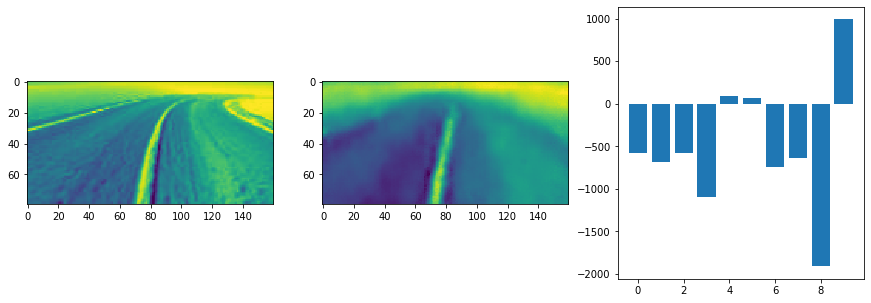

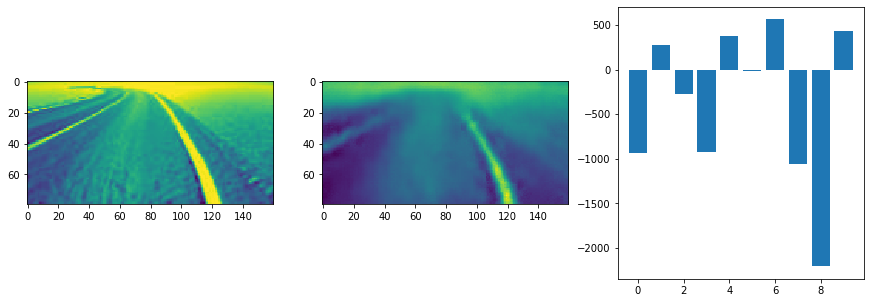

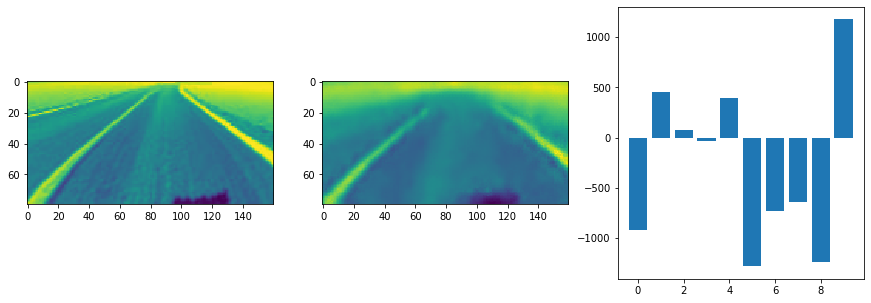

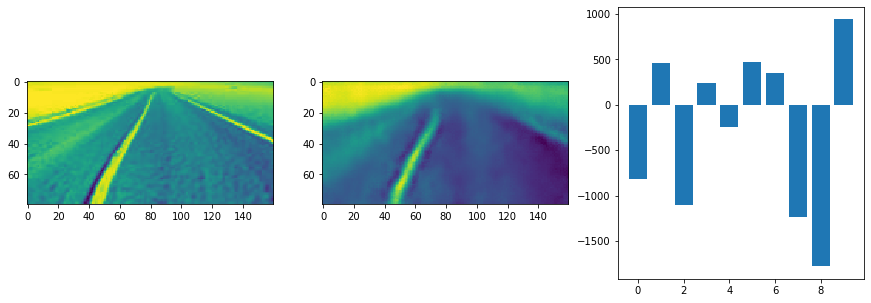

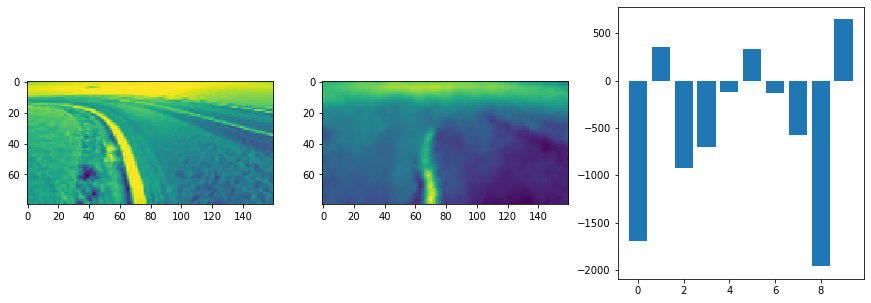

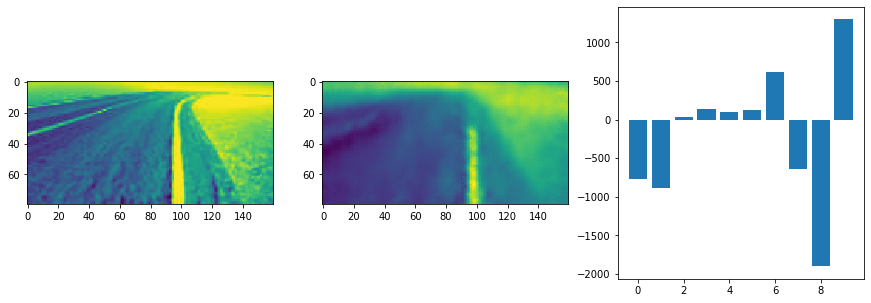

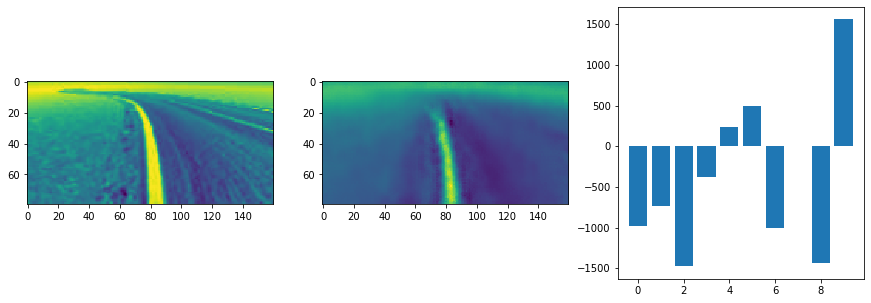

In [18]:
es2 = []
for im in test[:10]:
    embedding = encoder(im[np.newaxis, :].to(device))
    reconstruction = decoder(embedding).detach().cpu()
    
    e = embedding.detach().cpu().squeeze()
    es2.append(e)
    
    plt.figure(1, (15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction.squeeze())
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(len(e)), e)
    plt.show()

In [148]:
sys.getsizeof(decoder.state_dict())

1360

In [149]:
sys.getsizeof(encoder.state_dict())

1360

In [147]:
import sys

In [ ]:
embedding = encoder(im[np.newaxis, :].to(device))
    reconstruction = decoder(embedding).detach().cpu()
    
    e = embedding.detach().cpu().squeeze()
    es2.append(e)
    
    plt.figure(1, (15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction.squeeze())
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(len(e)), e)
    plt.show()embedding = encoder(im[np.newaxis, :].to(device))
    reconstruction = decoder(embedding).detach().cpu()
    
    e = embedding.detach().cpu().squeeze()
    es2.append(e)
    
    plt.figure(1, (15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction.squeeze())
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(len(e)), e)
    plt.show()

In [21]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

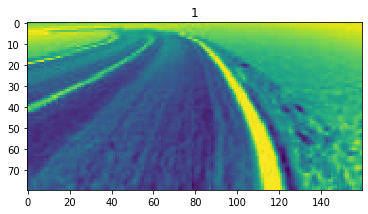

KeyboardInterrupt: 

In [90]:
for i in range(100):
    clear_output(wait=True)
    plt.title(i)
    plt.imshow(test[i].squeeze())
    plt.show()
    input()

In [93]:
def latent_space(a, b ,c, d, e, f, g, h, i, j):
    
    im = test[1]
    embedding = encoder(im[np.newaxis, :].to(device))
    
    
    #print(embedding[0][0])
    
    embedding[0][0] *= a
    embedding[0][1] *= b
    embedding[0][2] *= c
    embedding[0][3] *= d
    embedding[0][4] *= e
    embedding[0][5] *= f
    embedding[0][6] *= g
    embedding[0][7] *= h
    embedding[0][8] *= i
    embedding[0][9] *= j
    
    e = embedding.detach().cpu()[0]
    
    reconstruction = decoder(embedding).detach().cpu()
    
    plt.figure(1, (15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(reconstruction.squeeze())
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(len(e)), e)
    clear_output(wait=True)
    plt.show()

In [94]:
interact(latent_space, 
         a=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         b=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         c=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         d=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         e=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         f=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         g=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         h=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         i=widgets.FloatSlider(value = 1.0, min=-10.0, max=10), 
         j=widgets.FloatSlider(value = 1.0, min=-10.0, max=10))

interactive(children=(FloatSlider(value=1.0, description='a', max=10.0, min=-10.0), FloatSlider(value=1.0, des…

<function __main__.latent_space(a, b, c, d, e, f, g, h, i, j)>

In [80]:
a = widgets.FloatSlider?

In [ ]:
a = widgets.FloatSlider

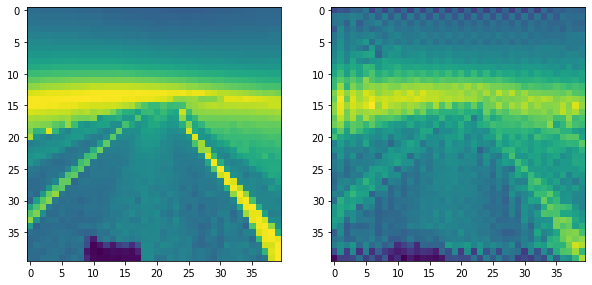

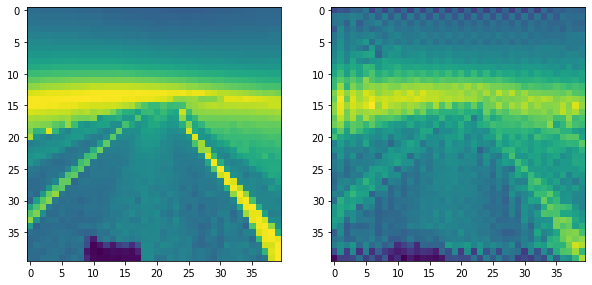

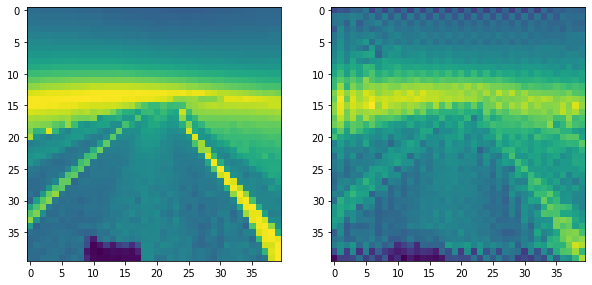

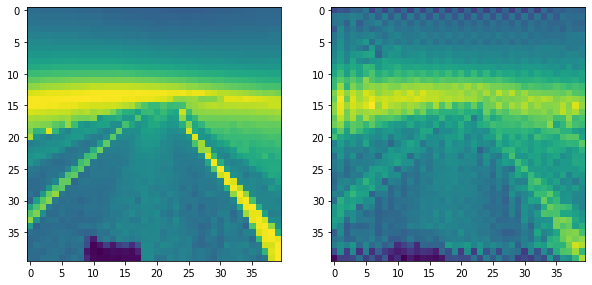

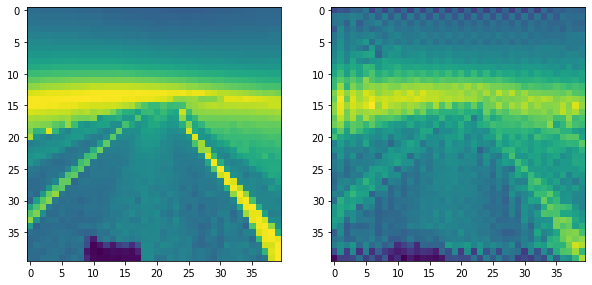

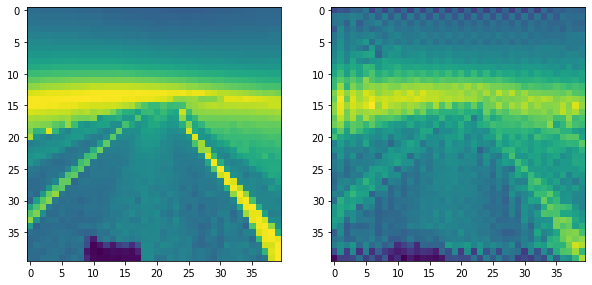

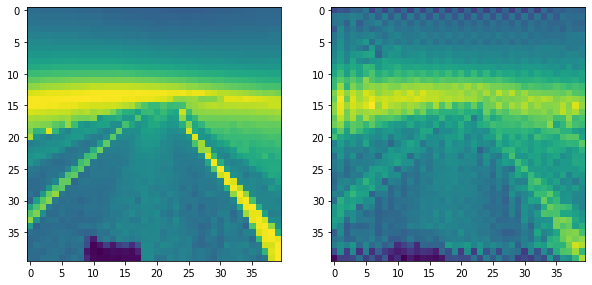

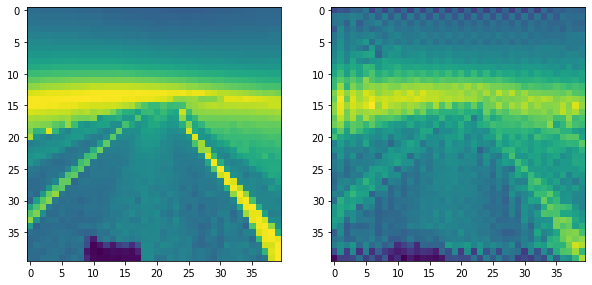

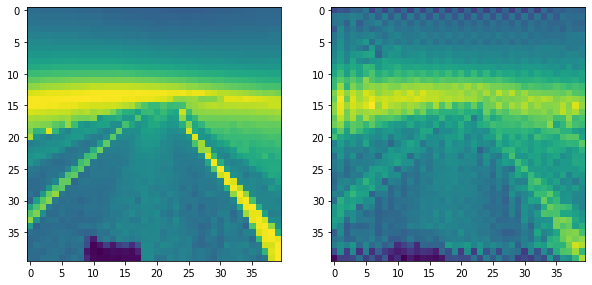

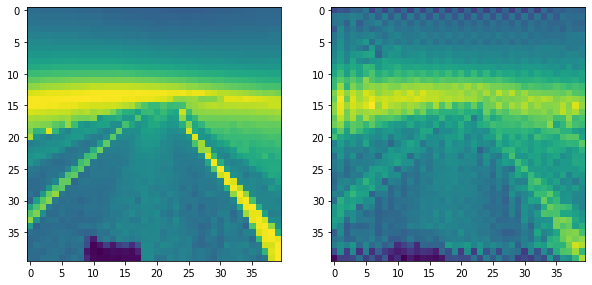

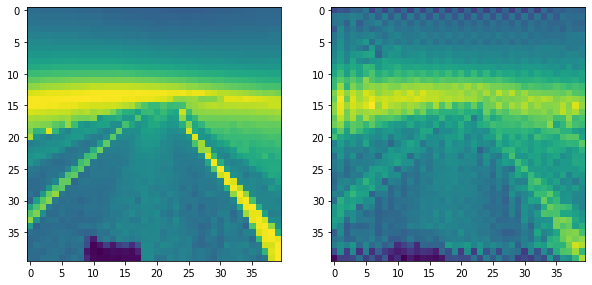

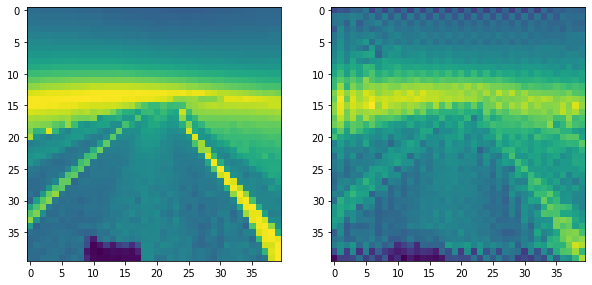

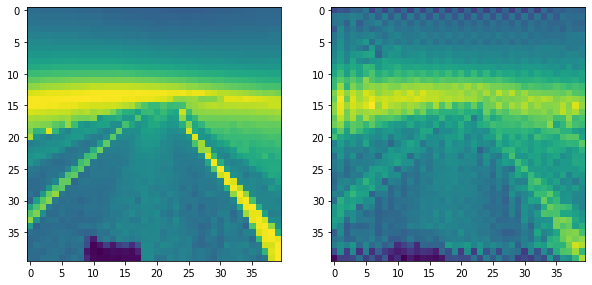

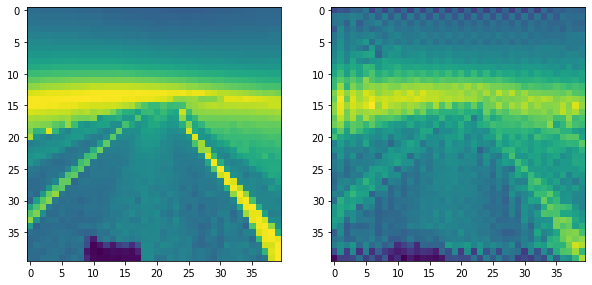

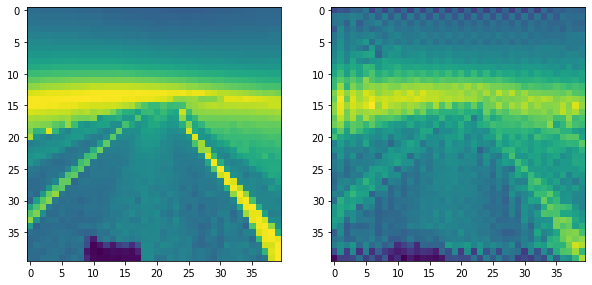

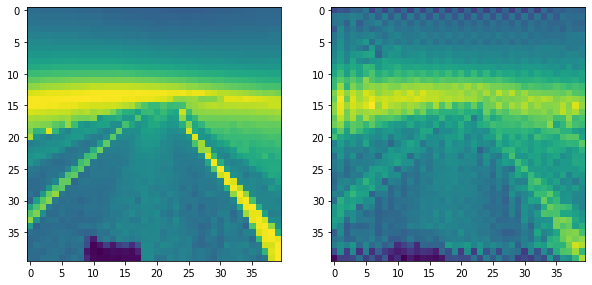

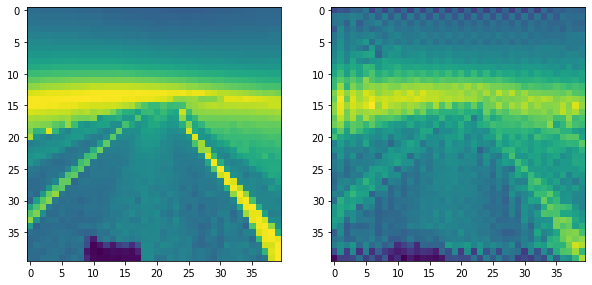

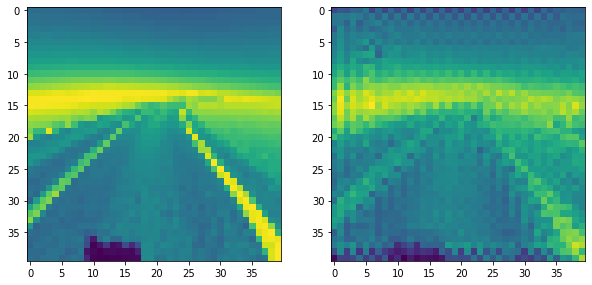

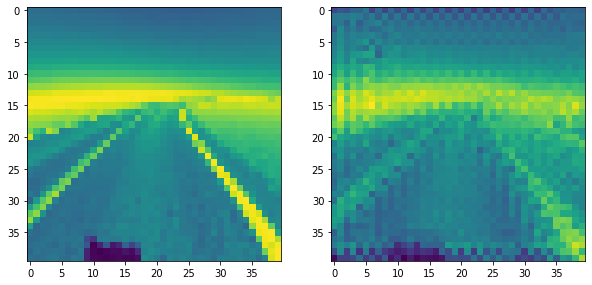

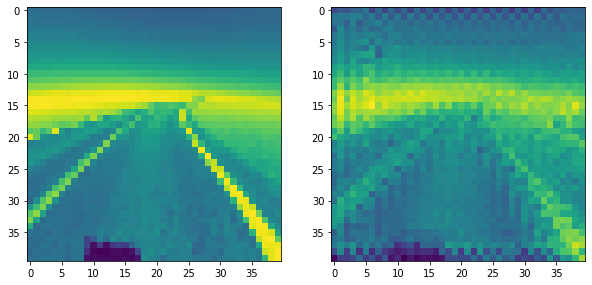

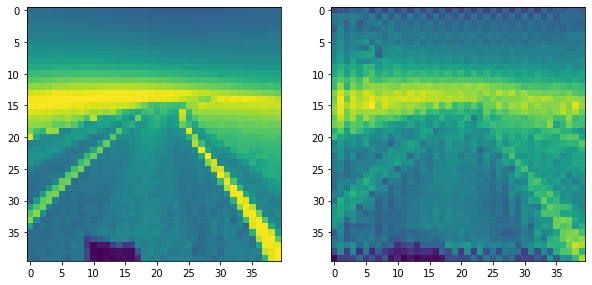

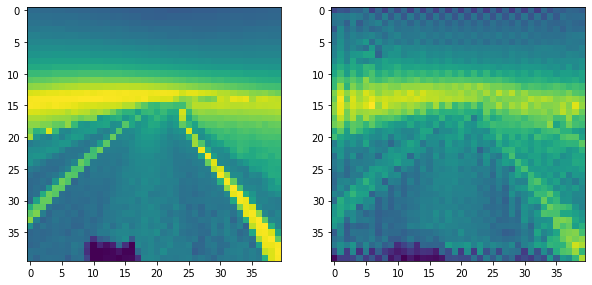

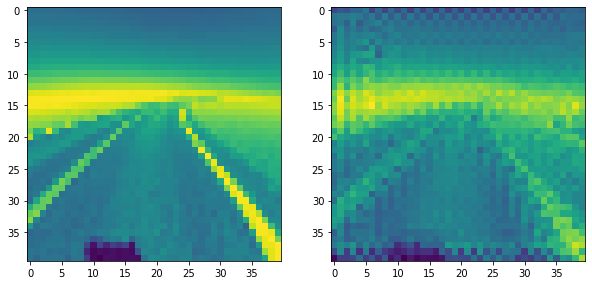

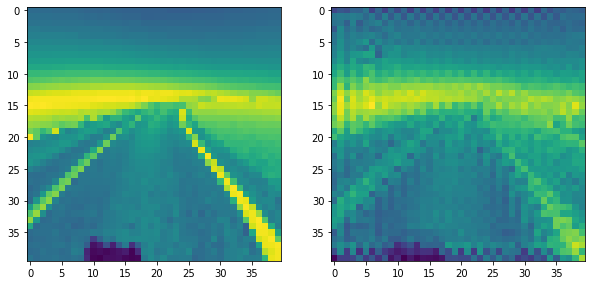

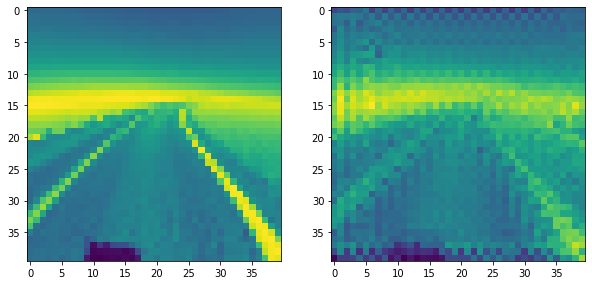

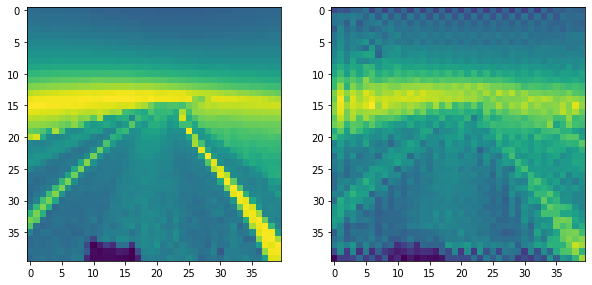

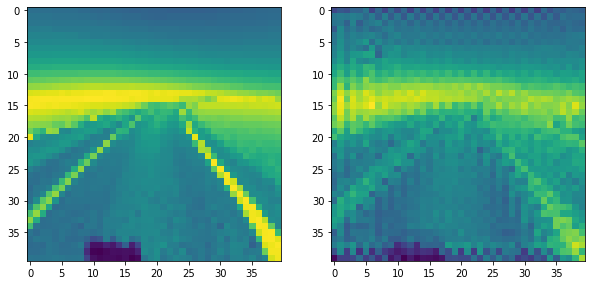

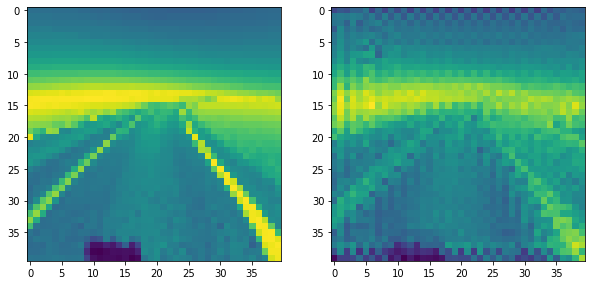

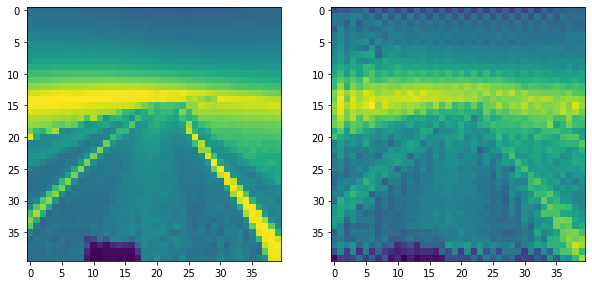

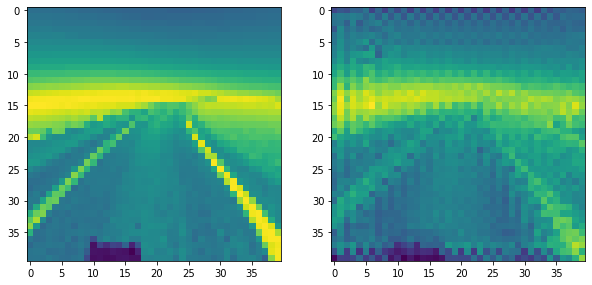

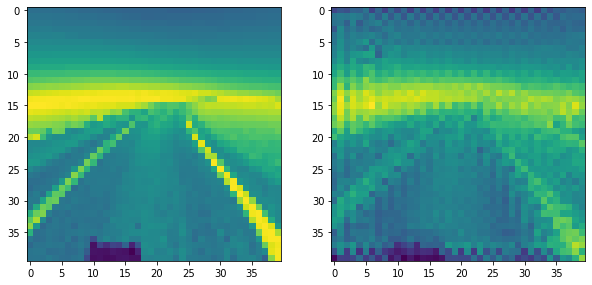

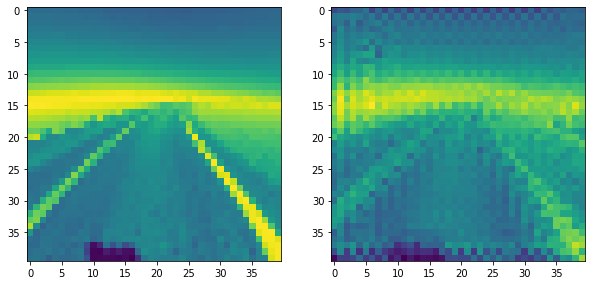

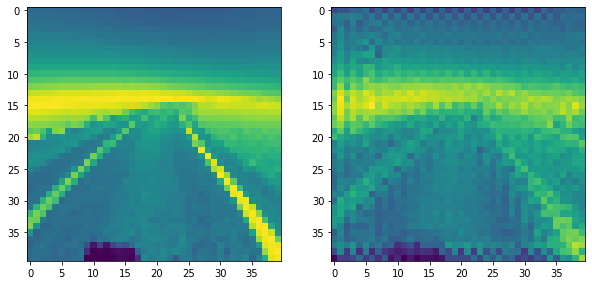

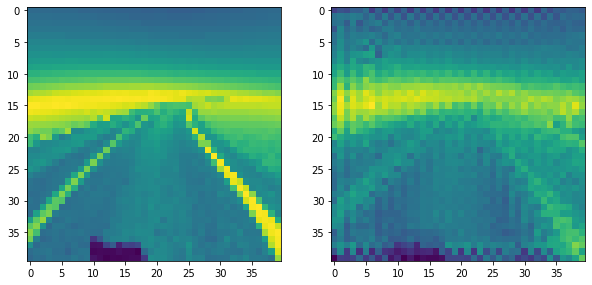

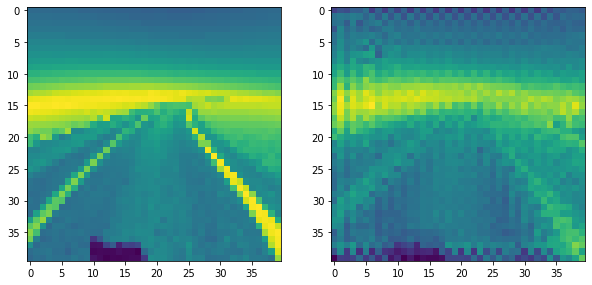

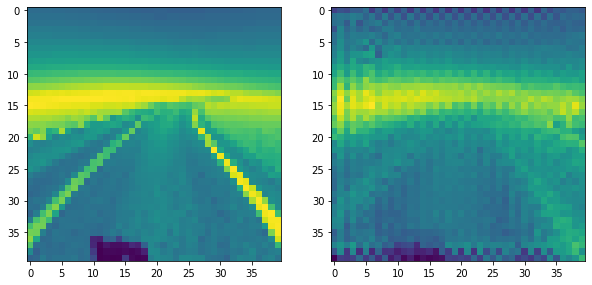

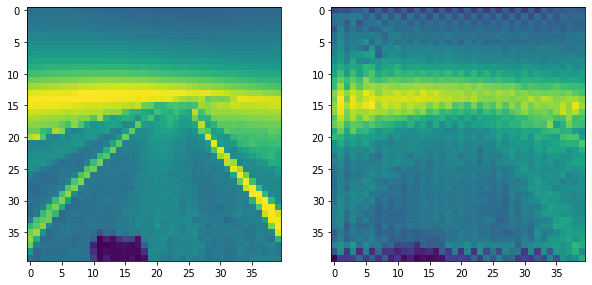

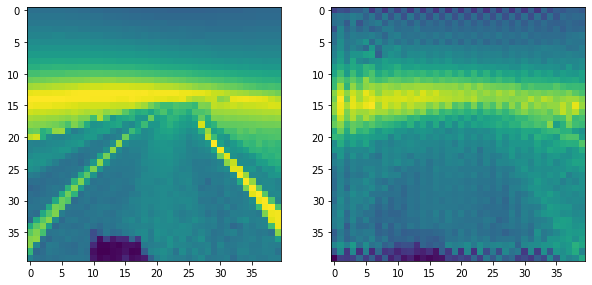

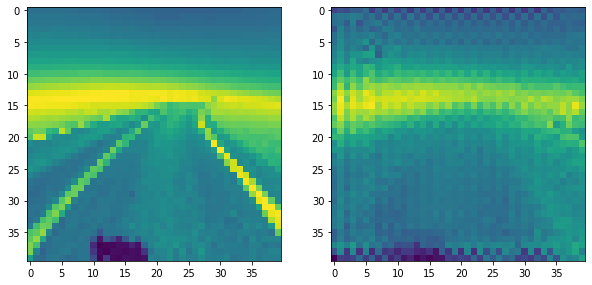

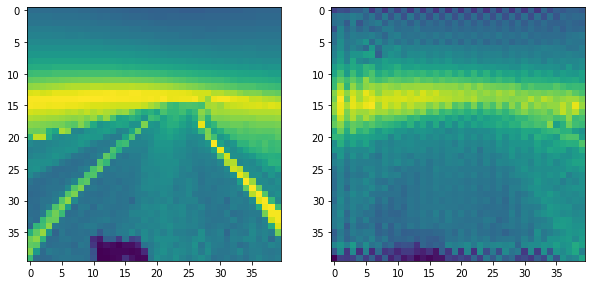

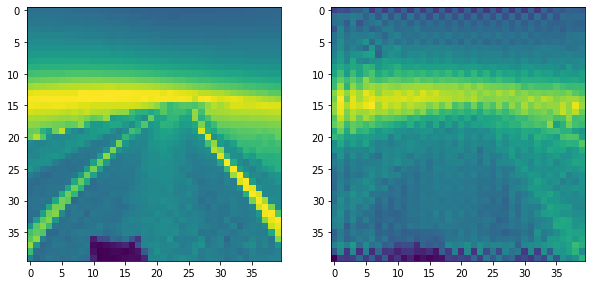

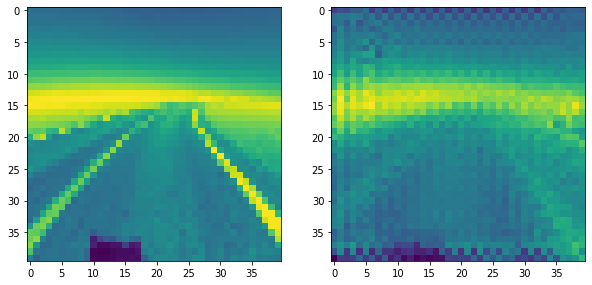

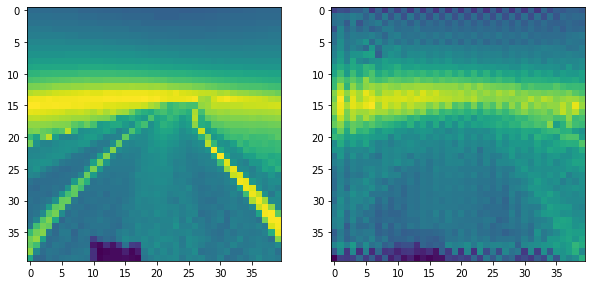

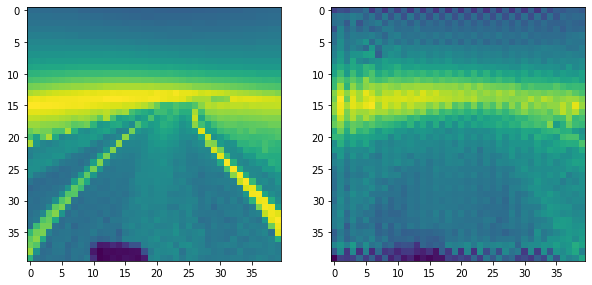

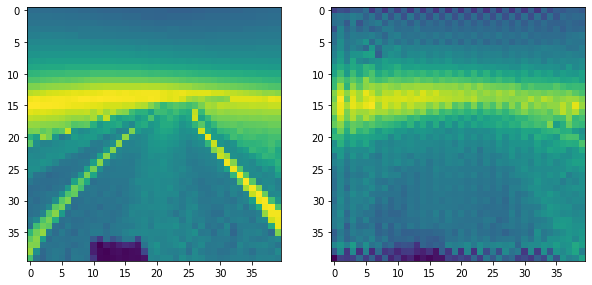

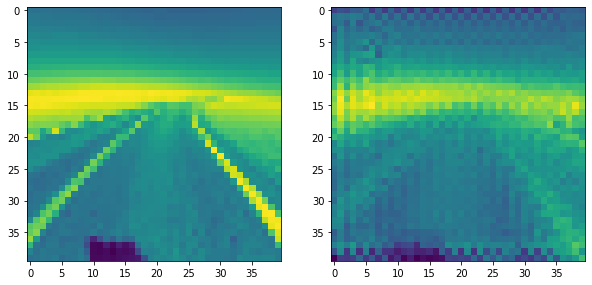

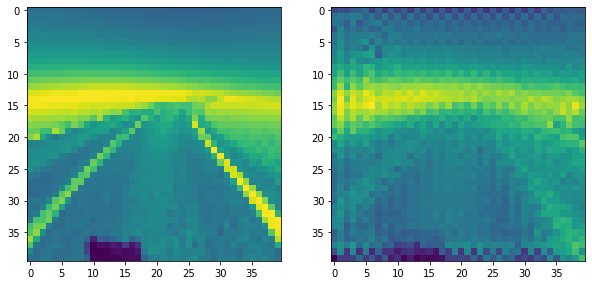

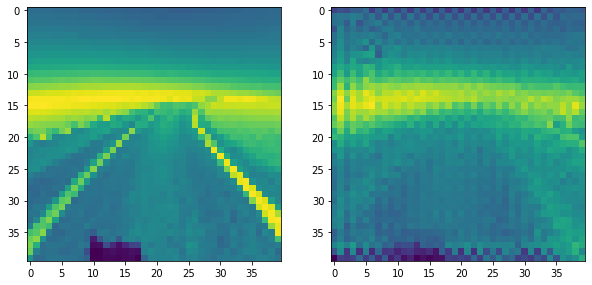

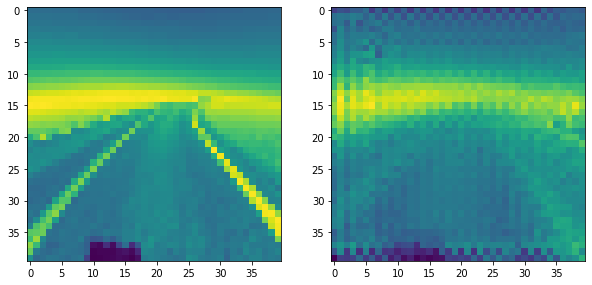

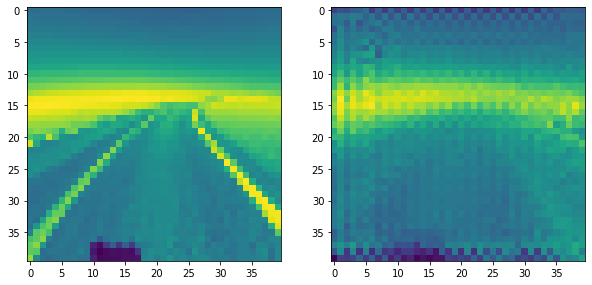

In [58]:
for im in test:
    embedding = encoder(im[np.newaxis, :].to(device))
    reconstruction = decoder(embedding).detach().cpu()
    
    plt.figure(1, (10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(im.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction.squeeze())
    plt.show()